In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.0.incompleteEDHT5W/cifar100-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.0.incompleteEDHT5W/cifar100-test.tfrecord


Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar100',
    version=3.0.0,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label')

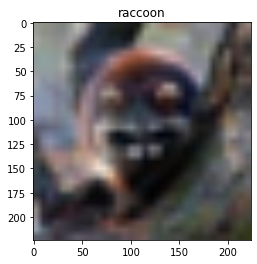

In [7]:
#SPLIT_WEIGHTS = (8, 1, 1)
#splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
dataset, info = tfds.load('cifar100', with_info=True, as_supervised=True)
print(info)
print(dataset)
# Format the Data
IMG_SIZE = 224 # All images will be resized to 224x224
@tf.function
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/255)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

# Apply this function to each item in the dataset using the map method:
cifar_train      = dataset['train'].map(format_example)
cifar_test       = dataset['test'].map(format_example)
print(cifar_train)
print(cifar_test)

get_label_name = info.features['label'].int2str

for image, label in cifar_train.take(1):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))


# New Section

In [0]:
# Now shuffle and batch the data.
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

cifar_train_batches      = cifar_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
#cifar_validation_batches = cifar_validation.batch(BATCH_SIZE)
cifar_test_batches       = cifar_test.batch(BATCH_SIZE)

for image_batch, label_batch in cifar_train_batches.take(1):
   pass
image_batch.shape

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

feature_batch = base_model(image_batch)
print(feature_batch.shape)
# freeze convolution base
base_model.trainable = False
base_model.summary()
# Add classification / fine tune part
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(100, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
# stack the base model (feature extraction), classification
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [9]:
SPLIT_WEIGHTS = (8, 1, 1)
# Train the model
num_train, num_val, num_test = (
  info.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

initial_epochs = 20
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

print(steps_per_epoch)

loss0,accuracy0 = model.evaluate(cifar_test_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1250
20/20 [==============================] - 1s 29ms/step - loss: 5.3064 - accuracy: 0.0125
initial loss: 5.31
initial accuracy: 0.01


In [0]:
history = model.fit(cifar_train_batches,
                    epochs=initial_epochs,
                    validation_data=cifar_test_batches)


Epoch 1/20
1563/1563 [==============================] - 86s 55ms/step - loss: 2.2548 - accuracy: 0.4313 - val_loss: 3.2447 - val_accuracy: 0.2995
Epoch 2/20
1563/1563 [==============================] - 86s 55ms/step - loss: 1.6741 - accuracy: 0.5487 - val_loss: 3.5285 - val_accuracy: 0.2943
Epoch 3/20
1563/1563 [==============================] - 87s 55ms/step - loss: 1.5391 - accuracy: 0.5771 - val_loss: 3.6478 - val_accuracy: 0.2916
Epoch 4/20
1563/1563 [==============================] - 85s 55ms/step - loss: 1.4561 - accuracy: 0.5998 - val_loss: 3.8316 - val_accuracy: 0.2805
Epoch 5/20
1563/1563 [==============================] - 85s 54ms/step - loss: 1.3920 - accuracy: 0.6124 - val_loss: 4.1029 - val_accuracy: 0.2731
Epoch 6/20
1563/1563 [==============================] - 85s 54ms/step - loss: 1.3473 - accuracy: 0.6234 - val_loss: 4.0369 - val_accuracy: 0.2805
Epoch 7/20
1563/1563 [==============================] - 86s 55ms/step - loss: 1.2995 - accuracy: 0.6346 - val_loss: 4.2569 -

In [0]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,8.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
# Un freeze base model
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
# Fine tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

len(model.trainable_variables)


In [0]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(cifar_train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=cifar_validation_batches)


In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

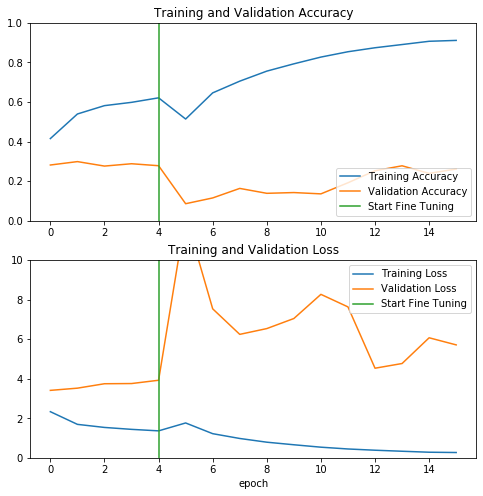

In [0]:
# plot the learning graphs
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 10.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [0]:
# Evaluate the model
test_steps = 20
test_loss, test_accuracy = model.evaluate(cifar_test_batches, steps = test_steps)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}".format(test_accuracy))


20/20 [==============================] - 1s 54ms/step - loss: 3.2995 - accuracy: 0.2828
Test loss: 3.30
Test accuracy: 0.28


In [0]:
# Convert Keras model to TF Lite format.
print(tf.__version__)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

2.0.0
Float model size = 9149KBs.


In [0]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 2369KBs,
which is about 25% of the float model size.


In [0]:
# Evaluate tensorflow lite model
cifar100 = tf.keras.datasets.cifar100
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# try just 100 images to save time
test_images = test_images[:100]
test_labesl = test_labels[:100]

def pre_process(image):
  image = tf.cast(image, tf.float32)
  image = (image/255)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image

# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = pre_process(test_image)
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    #print(test_image)
    #print(test_label)
    # test_image = test_image.astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)
    # Run inference.
    interpreter.invoke()
    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    # print(digit)
    prediction_digits.append(digit)
    # print(prediction_digits)
    # break

  #prediction_digits = np.array(prediction_digits)
  #test_label = np.array(test_label)
  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  #print('prediction_digits:', len(prediction_digits))
  #print(prediction_digits)
  #print('test_label:', test_label)
  for index in range(len(prediction_digits)):
    #print('pred:', prediction_digits[index])
    #print('label shape:', test_labels.shape)
    #print('label:', test_labels[index])
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits) 

  return accuracy

# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))


Float model accuracy = 0.2000
Quantized model accuracy = 0.1000
Accuracy drop = 0.1000


In [0]:
# Save the float model to file to the Downloads directory
f = open('/content/drive/My Drive/DeepGC/MobileNetV2/myMobileNetV2_float.tflite', "wb")
f.write(tflite_float_model)
f.close()

# Save the quantized model to file to the Downloads directory
f = open('/content/drive/My Drive/DeepGC/MobileNetV2/myMobileNetV2_quant.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the cifar classification model
# from google.colab import files
# files.download('/content/drive/My Drive/DeepGC/MobileNetV2/myMobileNetV2.tflite')
# print('`myMobileNetV2` has been downloaded')